## Exercise 1

In [1]:
import pandas as pd
from math import log2
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

SEED = 42
Y = "SalePrice"
path = "AmesHousing.csv"
df = pd.read_csv(path)

/Users/mike.verheijden/github/jads-discover-projects/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Exercise 2 

In [3]:
# Following variables are
#     - numerical (`float64(11), int64(28)`):
#     - categorical (`object(43)`):
#     - both (`(82)`)
df.info()
# - most of the variables are complete, exception of some like: `"Alley", "Mas Vnr Type", "Fireplace Qu", "Pool QC", "Fence", "Misc Feature"`
#     `SalePrice` is _complete_

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [4]:
# for freq table, see `nans_count` dictionary
nans_count: dict[str, int] = {}
for col in df.columns:
    # total rows - counted rows (since NaNs are not existing values)
    nans_count[col] = len(df) - df[col].count()

In [5]:
df["SalePrice_log"] = np.log(df[Y])

Y = "SalePrice_log"

df[["SalePrice", "SalePrice_log"]]

,SalePrice,SalePrice_log
0,215000,12.278393
1,105000,11.561716
2,172000,12.055250
3,244000,12.404924
4,189900,12.154253
...,...,...
2925,142500,11.867097
2926,131000,11.782953
2927,132000,11.790557
2928,170000,12.043554


In [6]:
# below are 2 descriptive summaries about the categorical and numeric data
numeric_df = df.select_dtypes("number")
numeric_df.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,SalePrice_log
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,...,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068,12.020969
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,...,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357,0.407587
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000,9.456341
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000,11.771436
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000,11.982929
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000,12.271392
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000,13.534473


In [7]:
categorical_df = df.select_dtypes("object")
categorical_df.describe()

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
count,2930,2930,198,2930,2930,2930,2930,2930,2930,2930,...,2773,2771,2771,2771,2930,13,572,106,2930,2930
unique,7,2,2,4,4,3,5,3,28,9,...,6,3,5,5,3,4,4,5,10,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,2273,2918,120,1859,2633,2927,2140,2789,443,2522,...,1731,1231,2615,2665,2652,4,330,95,2536,2413


In [8]:
# calc the mode (most frequent value), but to only show 1 row, we set dropna to False for readability (even tho NaN is most frequent value)
categorical_df.mode(dropna=False)

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [9]:
df["Alley"].value_counts(dropna=False)

Alley
NaN     2732
Grvl     120
Pave      78
Name: count, dtype: int64

## Exercise 3

In [10]:
num_df = df.select_dtypes("number")
df[num_df.columns] = df[num_df.columns].fillna(num_df.median())
# set as category for mem usage reduction
# df[num_cols.columns] = num_cols.astype("")

In [11]:
cat_df = df.select_dtypes("object")
df[cat_df.columns] = df[cat_df.columns].fillna("other")
# set as category for mem usage reduction
df[cat_df.columns] = df[cat_df.columns].astype("category")

In [12]:
df.isnull().values.any()

np.False_

In [13]:
# correctly downcasting to the lowest subtype for low memory usage
# thanks to: https://stackoverflow.com/questions/65842209/how-to-downcast-numeric-columns-in-pandas
downcast_mapping = {"number": "integer", "float": "float"}
for k, v in downcast_mapping.items():
    cols = df.select_dtypes(k).columns
    df[cols] = df[cols].apply(pd.to_numeric, downcast=v)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 83 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Order            2930 non-null   int16   
 1   PID              2930 non-null   int32   
 2   MS SubClass      2930 non-null   int16   
 3   MS Zoning        2930 non-null   category
 4   Lot Frontage     2930 non-null   int16   
 5   Lot Area         2930 non-null   int32   
 6   Street           2930 non-null   category
 7   Alley            2930 non-null   category
 8   Lot Shape        2930 non-null   category
 9   Land Contour     2930 non-null   category
 10  Utilities        2930 non-null   category
 11  Lot Config       2930 non-null   category
 12  Land Slope       2930 non-null   category
 13  Neighborhood     2930 non-null   category
 14  Condition 1      2930 non-null   category
 15  Condition 2      2930 non-null   category
 16  Bldg Type        2930 non-null   category


In [15]:
# set this as a variable so that it can be used for easy init of df (see config.py)
dtypes_dict = df.dtypes.apply(lambda x: x.name).to_dict()

## Exercise 4

In [16]:
desc = df.SalePrice.describe()
desc["median"] = df.SalePrice.median(0)
desc

count       2930.000000
mean      180796.060068
std        79886.692357
min        12789.000000
25%       129500.000000
50%       160000.000000
75%       213500.000000
max       755000.000000
median    160000.000000
Name: SalePrice, dtype: float64

<Axes: >

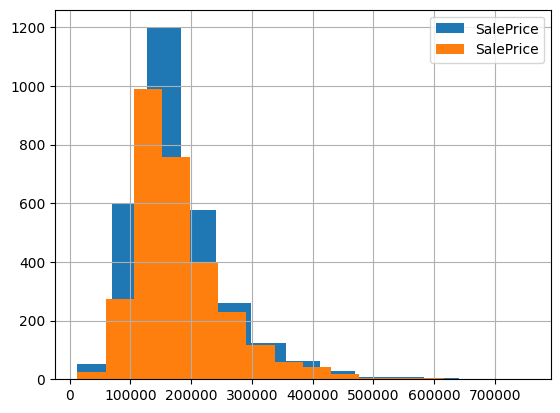

In [17]:
def calc_bins_iqr(series: pd.Series) -> int:
    # TODO
    return 0


def calc_bins_sturges(series: pd.Series) -> int:
    """calc bins using Sturge's rules"""

    n = len(series)

    return round(log2(n) + 1)


df.SalePrice.hist(bins=calc_bins_sturges(df.SalePrice), legend=True)
df.SalePrice.hist(bins=16, legend=True)  # taken fom pieters example
# observation: most houses have a sale price of around 100k to 250k, with a peak at 150k


# which means there is going to be a bias towards this peak if the test/train split is not equally divided

# this graph shows that it has a right-sided skewness

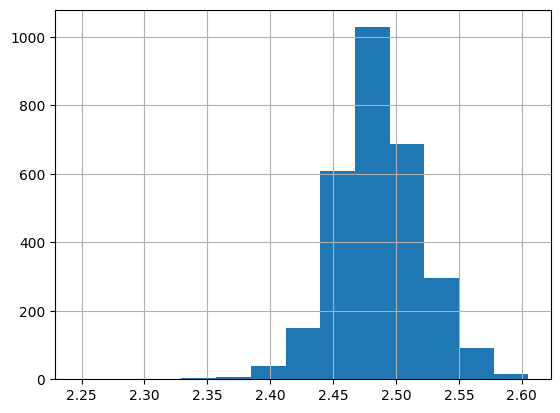

In [18]:
df["SalePrice_log"] = np.log(df[Y])
df["SalePrice_log"].hist(bins=calc_bins_sturges(df["SalePrice_log"]))
filled_df = df.copy()

<Axes: xlabel='Gr Liv Area', ylabel='SalePrice_log'>

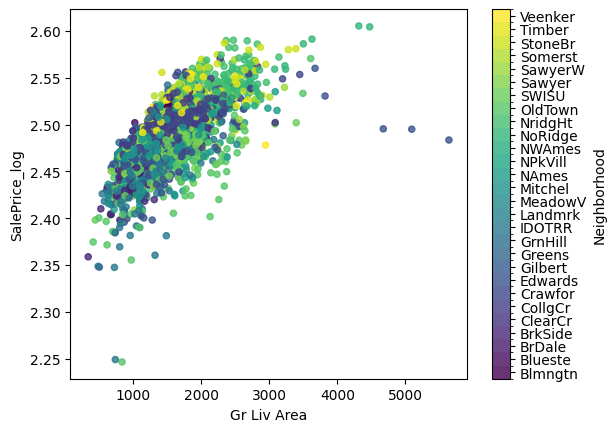

In [19]:
# By changing the transparency of each observation, we can see better patterns (`alpha` kwarg)
x = "Gr Liv Area"
df.plot.scatter(x=x, y=Y, alpha=0.8, c="Neighborhood", colormap="viridis")

<Axes: xlabel='Gr Liv Area', ylabel='SalePrice_log'>

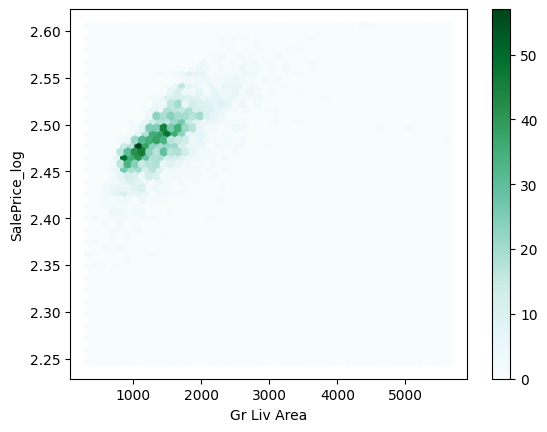

In [20]:
# to further check the data density of the scatterplot, we can check it using a 2D histogram heatmap, also known as a `hexagonal binning plot`
df.plot.hexbin(x=x, y=Y, gridsize=50)

In [21]:
# removal of outliers, outliers are defined by calculating their respective z-score
array = df["Gr Liv Area"]
df["Gr Liv Area_zscores"] = np.abs((array - array.mean()) / array.std())
outliers = df[df["Gr Liv Area_zscores"] > 2]
outliers[["Gr Liv Area"]]
# removing the outliers narrows the scope of the model and adds to the bias!

,Gr Liv Area
15,3279
46,2696
59,2599
62,2622
65,3238
...,...
2747,2559
2880,480
2891,2519
2897,2514


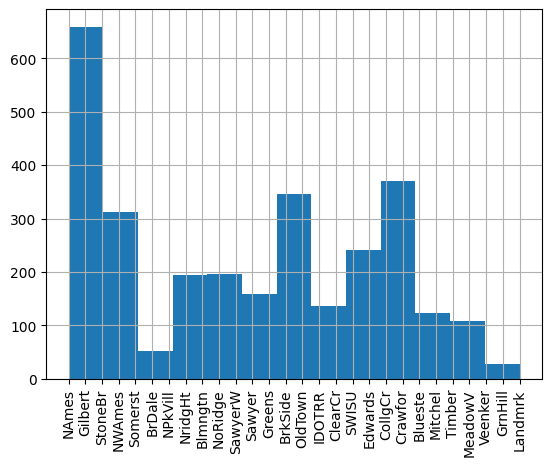

In [22]:
hist = df.Neighborhood.hist(bins=calc_bins_sturges(df.Neighborhood))
plt.xticks(rotation=90)
plt.show()

In [23]:
df.Neighborhood.value_counts()

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: count, dtype: int64

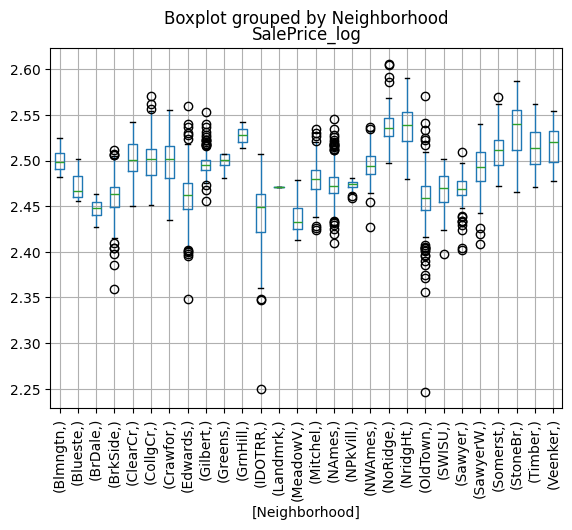

In [24]:
boxplot = df.boxplot(column=[Y], by=["Neighborhood"])
plt.xticks(rotation=90)
plt.show()

In [25]:
df.SalePrice.describe()

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

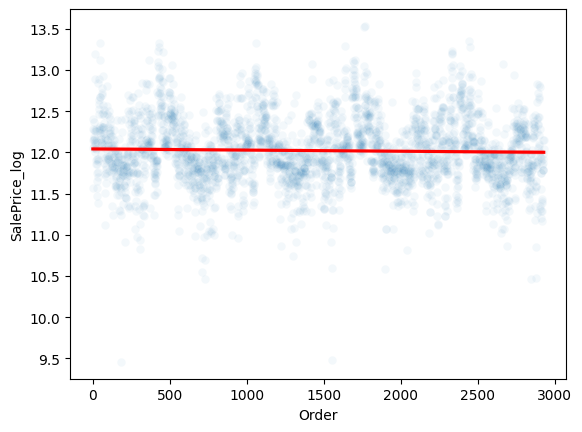

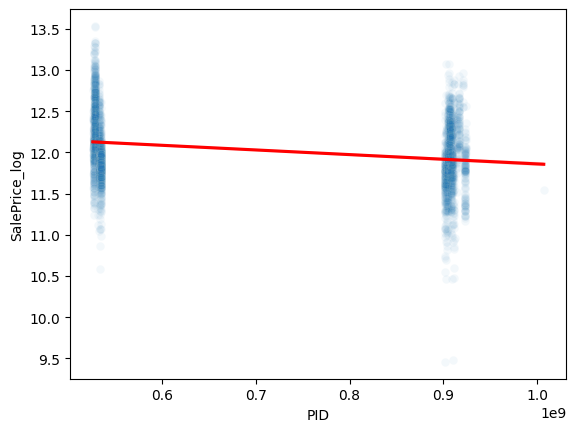

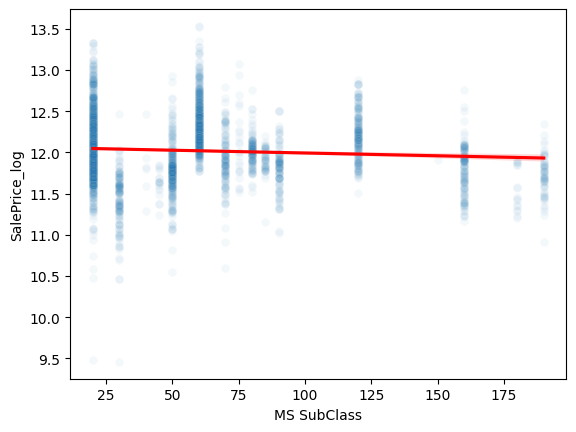

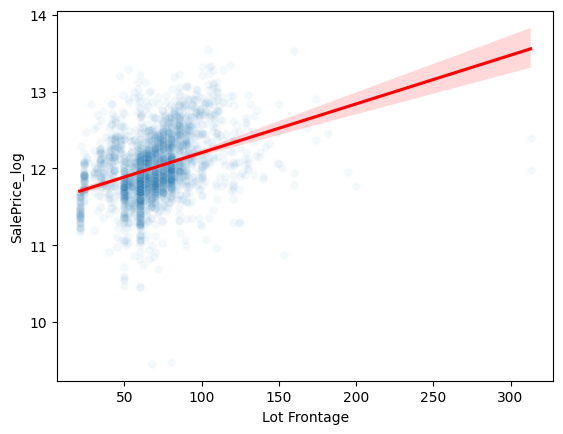

In [26]:
amount = 4  # to prevent 20 figures from opening in notebook
num_cols = [c for c in numeric_df.columns]
for col in num_cols[:amount]:
    # use seaborn in order to add a trendline to the plot

    plt.figure()
    sns.scatterplot(x=numeric_df[col], y=numeric_df[Y], alpha=0.05)
    sns.regplot(x=numeric_df[col], y=numeric_df[Y], scatter=False, color="red")
    plt.show()

In [27]:
# Pearson correlation coefficients:
# most used manner in order to calculate a linear correlation,
# resulting in a correlation coefficient (r)
# 0<=1: positive corr
# 0: no corr
# -1=>0: negative corr
corr_table = numeric_df.corr()

<Axes: >

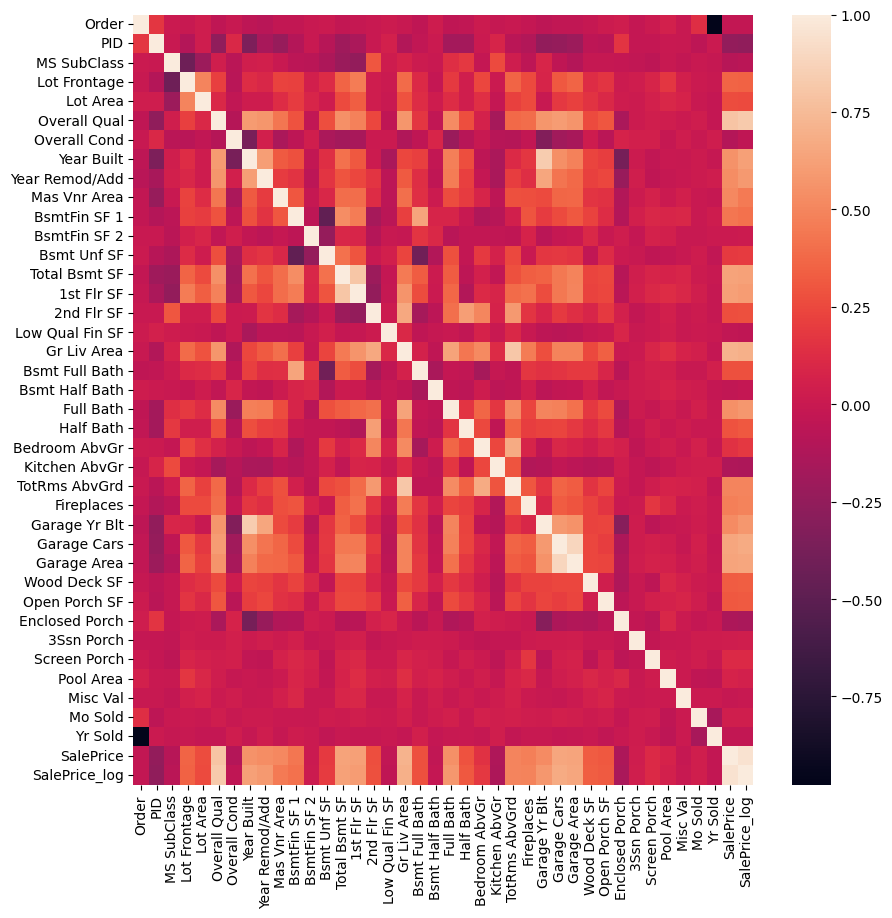

In [28]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr_table)

In [29]:
# determining key features for training the set
corr_table["SalePrice_log"].sort_values(ascending=False).head(10)

SalePrice_log     1.000000
SalePrice         0.946303
Overall Qual      0.825645
Gr Liv Area       0.695862
Garage Cars       0.675318
Garage Area       0.651132
Total Bsmt SF     0.625098
Year Built        0.615484
1st Flr SF        0.602629
Year Remod/Add    0.586153
Name: SalePrice_log, dtype: float64

In [30]:
# get the five mosst highly correlated featues as in relation to saleprice_log
key_features = ["Overall Qual", "Gr Liv Area", "Garage Cars", "Garage Area", "Total Bsmt SF"]

## Exercise 5

First model that is trained is a linear regression model.

In [31]:
# https://stackoverflow.com/questions/36631163/what-are-the-pros-and-cons-between-get-dummies-pandas-and-onehotencoder-sciki
# removed this line according to consistency mentioned in stack thread in abovementioned url

# preprocess filled_df to be fully numerical data for the linear regression model using
# one hot encoding to replace the categorical columns with numeric ones (in the original df)
# filled_df = pd.get_dummies(filled_df, columns=categorical_df.columns.to_list(), drop_first=True)

In [32]:
filled_df.shape

(2930, 83)

In [33]:
y_df = filled_df.loc[:, filled_df.columns == Y]
X_df = filled_df.loc[:, filled_df.columns != Y]

In [34]:
X_df

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141,31770,Pave,other,IR1,Lvl,...,0,other,other,other,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80,11622,Pave,other,Reg,Lvl,...,0,other,MnPrv,other,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81,14267,Pave,other,IR1,Lvl,...,0,other,other,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93,11160,Pave,other,Reg,Lvl,...,0,other,other,other,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74,13830,Pave,other,IR1,Lvl,...,0,other,MnPrv,other,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37,7937,Pave,other,IR1,Lvl,...,0,other,GdPrv,other,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,68,8885,Pave,other,IR1,Low,...,0,other,MnPrv,other,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62,10441,Pave,other,Reg,Lvl,...,0,other,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77,10010,Pave,other,Reg,Lvl,...,0,other,other,other,0,4,2006,WD,Normal,170000


#### Using all features

In [35]:
# # using simple test/train split (holdout) using all features
# X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.20, shuffle=False, random_state=SEED)


# # raw data
# model = LinearRegression().fit(X_train, y_train)
# holdout_score = model.score(X_test, y_test)
# print(f"raw with holdout: {holdout_score}")

In [36]:
# # using a dedicated KFold object for cross validation
# kf = KFold(n_splits=5, random_state=SEED, shuffle=True)
# model = LinearRegression()
# scores = cross_val_score(model, X_df, y_df, cv=kf, n_jobs=-1)
# kfold_score = [np.mean(scores), np.std(scores)]
# print(kfold_score)

In [37]:
# # using cross_val_score for cross validation (which underwater makes a KFold object)
# model = LinearRegression()
# scores = cross_val_score(model, X_df, y_df, n_jobs=-1)
# kfold_score = [np.mean(scores), np.std(scores)]
# print(kfold_score)

In [38]:
# print(f"difference between using holdout and kfold is {(kfold_score[0] - holdout_score)*100}%")

#### using subset of key features

In [39]:
y_df = filled_df.loc[:, filled_df.columns == Y]
X_df = filled_df.loc[:, filled_df.columns.isin(key_features)]
# show what the filtered full df looks like
filled_df[key_features + [Y]]

,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Total Bsmt SF,SalePrice_log
0,6,1656,2,528,1080,2.507841
1,5,896,1,730,882,2.447699
2,6,1329,1,312,1329,2.489500
3,7,2110,2,522,2110,2.518093
4,5,1629,2,482,928,2.497679
...,...,...,...,...,...,...
2925,6,1003,2,588,1003,2.473770
2926,5,902,2,484,864,2.466654
2927,5,970,0,0,912,2.467299
2928,5,1389,2,418,1389,2.488529


In [40]:
# using simple test/train split (holdout) using all features
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.20, shuffle=False, random_state=SEED)

model = LinearRegression().fit(X_train, y_train)

print(model.__dict__)
print(f"formula (as taken from the model.__dict__, Y=b0(intercept+b1*x1): Y={model.__dict__["intercept_"]} + {model.__dict__["coef_"]}")

y_pred = model.predict(X_test)
print(
    f"""
    Holdout linear regression 
    R2 score = {model.score(X_test, y_test)},
    MSE = {metrics.mean_squared_error(y_pred, y_test)}
    """
)

{'fit_intercept': True, 'copy_X': True, 'n_jobs': None, 'positive': False, 'feature_names_in_': array(['Overall Qual', 'Total Bsmt SF', 'Gr Liv Area', 'Garage Cars',
       'Garage Area'], dtype=object), 'n_features_in_': 5, 'coef_': array([[1.15010823e-02, 1.19442365e-05, 1.62337290e-05, 8.40364661e-03,
        2.23217395e-06]]), 'rank_': 5, 'singular_': array([2.88134087e+04, 1.71351906e+04, 8.43165356e+03, 4.88834274e+01,
       1.62660346e+01]), 'intercept_': array([2.36322853])}
formula (as taken from the model.__dict__, Y=b0(intercept+b1*x1): Y=[2.36322853] + [[1.15010823e-02 1.19442365e-05 1.62337290e-05 8.40364661e-03
  2.23217395e-06]]

    Holdout linear regression 
    R2 score = 0.82807575145086,
    MSE = 0.0001898560648198522
    


In [41]:
# Standardization using standardscaler
x_scaler_train = StandardScaler().fit(X_train)
info_df = pd.DataFrame({"name": key_features, "mean": x_scaler_train.mean_, "std": x_scaler_train.scale_})


# using the scaler fitted on train data in order to prevent data leakage to test set
x_train_scaled = pd.DataFrame(x_scaler_train.transform(X_train), columns=key_features)
x_test_scaled = pd.DataFrame(x_scaler_train.transform(X_test), columns=key_features)

# train/fit on the original y_train set (without mods)
model = LinearRegression().fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)

# see relevant coeffients
info_df["coeff"] = model.coef_[0]
display(info_df)


print(
    f"""
MAE = {metrics.mean_absolute_error(y_test, y_pred)}
MSE = {metrics.mean_squared_error(y_test, y_pred)}
RMSE = {metrics.root_mean_squared_error(y_test, y_pred)}
"""
)

,name,mean,std,coeff
0,Overall Qual,6.115188,1.413746,0.016260
1,Gr Liv Area,1057.290529,450.596879,0.005382
2,Garage Cars,1504.893771,509.857046,0.008277
3,Garage Area,1.775597,0.759458,0.006382
4,Total Bsmt SF,475.581485,216.298368,0.000483



MAE = 0.010164377189032568
MSE = 0.00018985606481985447
RMSE = 0.013778826685166428



In [42]:
# # using kfold cross validation
# kf = KFold(n_splits=5, random_state=SEED, shuffle=True)
# model = LinearRegression()
# scores = cross_val_score(model, X_df, y_df, cv=kf, n_jobs=-1, scoring="neg_mean_squared_error")
# mse = -np.mean(scores)
# scores = cross_val_score(model, X_df, y_df, cv=kf, n_jobs=-1, scoring="r2")
# r2 = np.mean(scores)
# print(
#     f"""
#     Kfold linear regression
#     R2 score = {r2},
#     avg MSE = {mse}
#     """
# )

In [43]:
# # using cross_val_score for cross validation (which underwater makes a KFold object)
# model = LinearRegression()
# scores = cross_val_score(
#     model, X_df, y_df, n_jobs=-1
# )  # returns R^2 since cross_val_score returns the .score() funciton of the model that is given as input
# kfold_score = [np.mean(scores), np.std(scores)]
# print(kfold_score)

##### LASSO

In [44]:
# # lasso for holdout set
# # lassocv for cross validation set


# model = Lasso(random_state=SEED).fit(X_df, y_df)
# print(model.score(X_test, y_test))


# print("------------------")

# y = y_df.values.ravel()

# alphas = np.arange(0.0001, 0.01, 0.0005)
# model = LassoCV(alphas=alphas, random_state=SEED).fit(X_df, y)
# print(
#     f"""
# alphas within the model: {model.alpha_}
# R2 score: {model.score(X_test, y_test)}
# """
# )

# print("------------------")

# model = LassoCV(random_state=SEED).fit(X_df, y)
# print(
#     f"""
# alphas within the model: {model.alpha_}
# R2 score: {model.score(X_test, y_test)}
# """
# )

In [45]:
# neighbourhood has a high correlation with saleprice, hence we will include this into the
# dataset aswell (one hot encoded)
# the OHE cols are formatted as `Neighborhood_<name>`, so correcetly format them
# nhoods_cols = [f"Neighborhood_{i}" for i in df["Neighborhood"].unique().tolist()]

In [46]:
# # scenario A (without OHE nhoods)
# y_df = filled_df.loc[:, filled_df.columns == Y]
# y_df = y_df.values.ravel()
# # throw everything at lasso since lasso will filter out features that are valuable
# X_df = filled_df.loc[:, filled_df.columns != Y]
# # X_df = filled_df.loc[:, filled_df.columns.isin(key_features)]

# X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.20, shuffle=False, random_state=SEED)

# scaled_on_X = StandardScaler().fit(X_train)
# X_train = pd.DataFrame(data=scaled_on_X.transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(data=scaled_on_X.transform(X_test), columns=X_test.columns)

# alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
# folds = 5
# lasso = LassoCV(cv=folds, random_state=SEED, max_iter=1000, alphas=alphas).fit(X_train, y_train)

# print(f"Chosen alpha by cross validation = {lasso.alpha_}")


# df = pd.DataFrame(data=lasso.mse_path_, columns=[f"fold{i}" for i in range(folds)]).T
# print("MSE")
# display(df)

# print("RMSE")
# display(np.sqrt(df))

In [47]:
# lasso.alphas_

In [48]:
# scenario B (with OHE nhoods)
# key_features = key_features + nhoods_cols
# y_df = filled_df.loc[:, filled_df.columns == Y]
# X_df = filled_df.loc[:, filled_df.columns.isin(key_features)]

### Exercise 7 - SHAP

In [49]:
# without OHE
numeric_df = numeric_df.drop(columns=["SalePrice"])
x = numeric_df.loc[:, numeric_df.columns != Y]
y = numeric_df.loc[:, numeric_df.columns == Y]
y = y.values.ravel()

# df takes 501 and np array gets 500 exactly, hence the `500-1`
x_subset, y_subset = x.loc[: 500 - 1], y[:500]

# print the counts
print(np.count_nonzero(y_subset))

500


In [50]:
# copypasta from ames-house-pieter-exercies-7-shap-exercis.ipynb
# Hyperparameter grid:
dc_hyperparameter_ranges = {
    "bootstrap": [True, False],  # Do we bootstrap samples, or not.
    "max_depth": [20],  # Maximum depth of each tree
    "min_samples_leaf": [4],  # Minimum number of samples required to be at a leaf node
    "min_samples_split": [4],  # Minimum number of samples required to split an internal node
    "n_estimators": [1000],  # Number of trees
    "max_features": ["sqrt", "log2"],  # Number of features to consider at each split
    "random_state": [42],  # Random state for reproducibility
}

# Perform a gridsearch on the random forest model:
gridsearch = GridSearchCV(
    estimator=RandomForestRegressor(), param_grid=dc_hyperparameter_ranges, scoring="neg_mean_squared_error", cv=5
)

# Use subset of training data to do a gridsearch on the random forest model:
gridsearch.fit(x_subset, y_subset)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False], 'max_depth': [20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [4], 'min_samples_split': [4],
                         'n_estimators': [1000], 'random_state': [42]},
             scoring='neg_mean_squared_error')

In [51]:
# best_params refer to the parameters that the best model has,
# the best_Estimator is the actual model that is trained as an object
best_model = gridsearch.best_estimator_
display(gridsearch.best_params_, best_model)

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 1000,
 'random_state': 42}

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=4, min_samples_split=4,
                      n_estimators=1000, random_state=42)

In [52]:
# Initialize JavaScript visualization support for SHAP (SHapley Additive exPlanations) plots.
shap.initjs()

# Create SHAP object.
explainer = shap.Explainer(best_model)

# Create SHAP values.
shap_values = explainer.shap_values(x_subset)

12.068555523241795


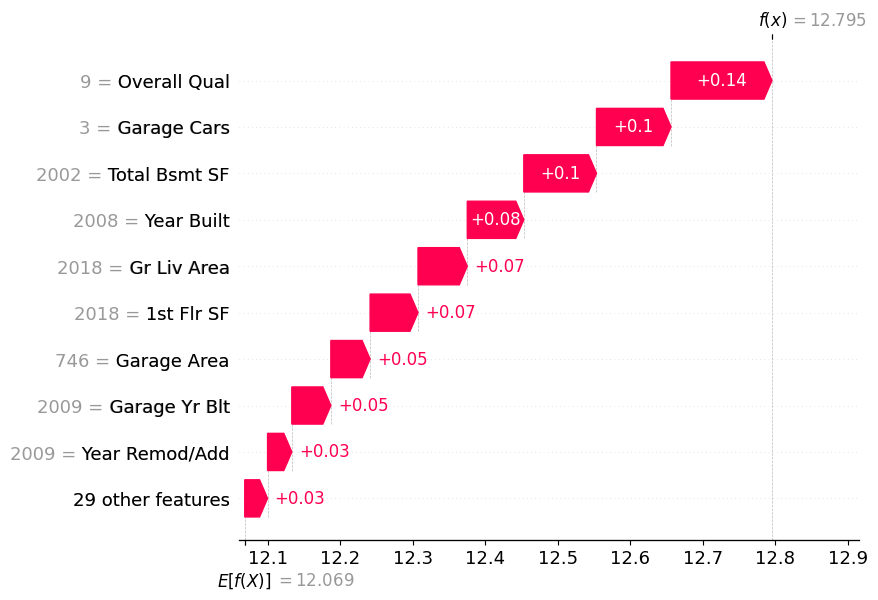

In [53]:
# Define index of data point you want to explain the prediction for.
data_idx = 321

print(explainer.expected_value[0])

# Plot waterfall
shap.plots.waterfall(
    shap.Explanation(
        base_values=explainer.expected_value[0],  # Mean prediction for the entire training data.
        values=shap_values[data_idx],  # Subset of shap values.
        data=x_subset.iloc[data_idx],  # Subset of training data.
        feature_names=x_subset.columns,  # Feature names.
    )
)

# conclusion:
# the red arrows positively influence the sale price f(x),
# the blue ones negatively impact them.
# so the more an dlonger red arrows, the higher the sale price of the property and vice versa

In [54]:
# Plot Force Plot.
shap.plots.force(
    base_value=explainer.expected_value[0],  # Mean prediction for the entire training data.
    shap_values=shap_values[data_idx],  # SHAP values.
    features=x_subset.iloc[data_idx],  # Training data.
    feature_names=x_subset.columns,  # Feature names.
)

In [55]:
data_idx = [9, 234, 67, 241]  # randomly
shap.plots.force(
    base_value=explainer.expected_value[0],  # Mean prediction for the entire training data.
    shap_values=shap_values[data_idx],  # SHAP values.
    features=x_subset.iloc[data_idx],  # Training data.
    feature_names=x_subset.columns,  # Feature names.
)

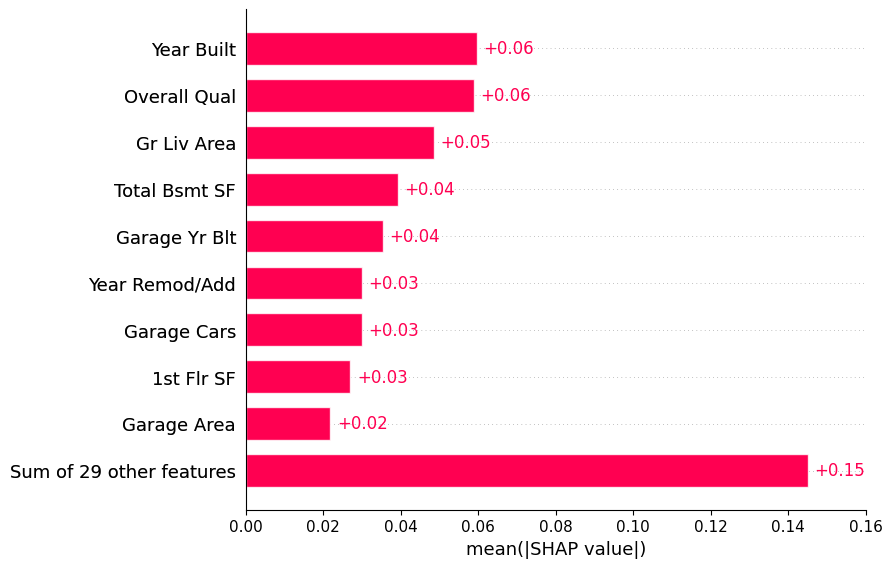

In [56]:
# Plot Mean SHAP.
shap.plots.bar(
    shap_values=shap.Explanation(
        base_values=explainer.expected_value[0],  # Mean prediction for the entire training data.
        values=shap_values,  # Subset of shap values.
        data=x_subset,  # Subset of training data.
        feature_names=x_subset.columns,  # Feature names.
    )
)
# total feature imoportancve based off of the SHAP values

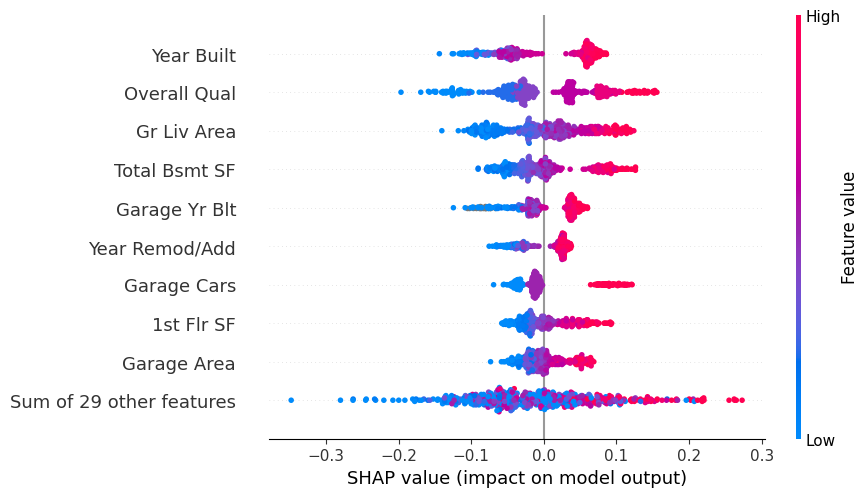

In [57]:
# Plot beeswarm plot.
shap.plots.beeswarm(
    shap.Explanation(
        base_values=explainer.expected_value[0],  # Mean prediction for the entire training data.
        values=shap_values,  # SHAP values.
        data=x_subset,  # Training data.
        feature_names=x_subset.columns,  # Feature names.
    )
)